In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [271]:
def remove_duplicates(lst):
    seen = set()
    seen_add = seen.add
    return [x for x in lst if not (x in seen or seen_add(x))]

def group(lst):
    grouped_bets = []
    iteration = 0
    for index in range(len(lst)/3):
        if lst[iteration*3] != "":
            grouped_bets.append((bet_houses[index], (lst[iteration*3], lst[iteration*3 + 1], lst[iteration*3 + 2])))
        iteration += 1
    return grouped_bets

bets_csv_file = sc.textFile("/home/gg6/BetsExploring/Data/Interim/main_competitions.csv")

bet_houses = remove_duplicates(bets_csv_file.map(lambda line: line.split(","))\
        .map(lambda line : map(lambda bet_house : bet_house[:-1], line[10:37])).take(1)[0])

bets = bets_csv_file.map(lambda line: line.split(","))\
        .filter(lambda line : line[0] != "Country").map(lambda line: (line[9], group(line[10:37])))
    
print("\nBet houses -> " + str(bet_houses))
print("\nBets by house -> " + str(bets.take(5)))


Bet houses -> [u'B365', u'BS', u'BW', u'GB', u'IW', u'LB', u'SJ', u'VC', u'WH']

Bets by house -> [(u'D', [(u'B365', (u'2.75', u'3.3', u'2.5')), (u'BW', (u'2.6', u'3.3', u'2.55')), (u'IW', (u'2.6', u'3.2', u'2.5')), (u'LB', (u'2.7', u'3.4', u'2.5')), (u'VC', (u'2.75', u'3.6', u'2.45')), (u'WH', (u'2.6', u'3.3', u'2.5'))]), (u'H', [(u'B365', (u'1.7', u'3.5', u'5.25')), (u'BW', (u'1.65', u'3.8', u'4.75')), (u'IW', (u'1.7', u'3.5', u'4.4')), (u'LB', (u'1.7', u'3.8', u'4.75')), (u'VC', (u'1.73', u'3.9', u'4.6')), (u'WH', (u'1.73', u'3.6', u'4.33'))]), (u'A', [(u'B365', (u'1.67', u'3.75', u'5.0')), (u'BW', (u'1.65', u'3.6', u'5.0')), (u'IW', (u'1.75', u'3.4', u'4.3')), (u'LB', (u'1.67', u'3.8', u'4.75')), (u'VC', (u'1.7', u'4.1', u'4.6')), (u'WH', (u'1.75', u'3.75', u'4.0'))]), (u'A', [(u'B365', (u'3.6', u'3.75', u'1.91')), (u'BW', (u'3.6', u'3.6', u'1.91')), (u'IW', (u'3.7', u'3.3', u'1.9')), (u'LB', (u'3.6', u'3.75', u'1.91')), (u'VC', (u'3.7', u'3.9', u'1.91')), (u'WH', (u'3.75', u'3.75

In [285]:
def bets_mean(bets):
    total_bets = len(bets)
    
    mean_home = 0.0
    mean_draw = 0.0
    mean_away = 0.0
    
    if(total_bets > 0):
    
        for bet in bets:
            try:
                mean_home += float(bet[1][0])
                mean_draw += float(bet[1][1])
                mean_away += float(bet[1][2])
            except:
                pass
        mean_home = mean_home / total_bets
        mean_draw = mean_draw / total_bets
        mean_away = mean_away / total_bets
    
    return(mean_home, mean_draw, mean_away)
    
bets_with_mean = bets.map(lambda line : (line[0], bets_mean(line[1]), line[1]))

print("Bets with mean -> " + str(bets_with_mean.take(5)))
    

Bets with mean -> [(u'D', (2.6666666666666665, 3.35, 2.5), [(u'B365', (u'2.75', u'3.3', u'2.5')), (u'BW', (u'2.6', u'3.3', u'2.55')), (u'IW', (u'2.6', u'3.2', u'2.5')), (u'LB', (u'2.7', u'3.4', u'2.5')), (u'VC', (u'2.75', u'3.6', u'2.45')), (u'WH', (u'2.6', u'3.3', u'2.5'))]), (u'H', (1.7016666666666669, 3.6833333333333336, 4.68), [(u'B365', (u'1.7', u'3.5', u'5.25')), (u'BW', (u'1.65', u'3.8', u'4.75')), (u'IW', (u'1.7', u'3.5', u'4.4')), (u'LB', (u'1.7', u'3.8', u'4.75')), (u'VC', (u'1.73', u'3.9', u'4.6')), (u'WH', (u'1.73', u'3.6', u'4.33'))]), (u'A', (1.6983333333333333, 3.733333333333333, 4.608333333333333), [(u'B365', (u'1.67', u'3.75', u'5.0')), (u'BW', (u'1.65', u'3.6', u'5.0')), (u'IW', (u'1.75', u'3.4', u'4.3')), (u'LB', (u'1.67', u'3.8', u'4.75')), (u'VC', (u'1.7', u'4.1', u'4.6')), (u'WH', (u'1.75', u'3.75', u'4.0'))]), (u'A', (3.658333333333333, 3.6749999999999994, 1.9083333333333332), [(u'B365', (u'3.6', u'3.75', u'1.91')), (u'BW', (u'3.6', u'3.6', u'1.91')), (u'IW', (u'

In [283]:
curious_ratio = 1.25

def evaluate_bets_over_mean(line):
    curious_home_bets = []
    curious_draw_bets = []
    curious_away_bets = []
    
    for bet in line[2]:
        try:
            if(float(bet[1][0]) >= line[1][0] * curious_ratio):
                curious_home_bets.append(bet[0])
            if(float(bet[1][1]) >= line[1][1] * curious_ratio):
                curious_draw_bets.append(bet[0])
            if(float(bet[1][2]) >= line[1][2] * curious_ratio):
                curious_away_bets.append(bet[0])
        except:
            pass
        
    return (curious_home_bets, curious_draw_bets, curious_away_bets)

curious_bets = bets_with_mean.map(lambda line : (line[0], evaluate_bets_over_mean(line)))
print("Bets over mean -> " + str(curious_bets.take(50)))

Bets over mean -> [(u'D', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [u'VC'])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'D', (

In [284]:
def evaluate_bets_under_mean(line):
    curious_home_bets = []
    curious_draw_bets = []
    curious_away_bets = []
    
    for bet in line[2]:
        try:
            if(float(bet[1][0]) <= line[1][0] / curious_ratio):
                curious_home_bets.append(bet[0])
            if(float(bet[1][1]) <= line[1][1] / curious_ratio):
                curious_draw_bets.append(bet[0])
            if(float(bet[1][2]) <= line[1][2] / curious_ratio):
                curious_away_bets.append(bet[0])
        except:
            pass
        
    return (curious_home_bets, curious_draw_bets, curious_away_bets)

curious_bets = bets_with_mean.map(lambda line : (line[0], evaluate_bets_under_mean(line)))
print("Bets under mean -> " + str(curious_bets.take(50)))

Bets under mean -> [(u'D', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [u'IW'])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'A', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'D', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'A', ([], [], [])), (u'D', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'H', ([], [], [])), (u'D', 

In [274]:
def maximum_bets(line):
    home_maximum = ("", 0.0)
    draw_maximum = ("", 0.0)
    away_maximum = ("", 0.0)
    
    for bet in line[1]:
        try:
            if(float(bet[1][0]) > home_maximum[1]):
                home_maximum = (bet[0], float(bet[1][0]))
            if(float(bet[1][1]) > draw_maximum[1]):
                draw_maximum = (bet[0], float(bet[1][1]))
            if(float(bet[1][2]) > away_maximum[1]):
                away_maximum = (bet[0], float(bet[1][2]))
        except:
            pass
    
    return (home_maximum, draw_maximum, away_maximum)

print("Maximum bets -> " + str(bets.map(lambda line: (line[0], maximum_bets(line))).take(10)))

Maximum bets -> [(u'D', ((u'B365', 2.75), (u'VC', 3.6), (u'BW', 2.55))), (u'H', ((u'VC', 1.73), (u'VC', 3.9), (u'B365', 5.25))), (u'A', ((u'IW', 1.75), (u'VC', 4.1), (u'B365', 5.0))), (u'A', ((u'WH', 3.75), (u'VC', 3.9), (u'B365', 1.91))), (u'A', ((u'B365', 3.2), (u'VC', 3.5), (u'LB', 2.25))), (u'D', ((u'IW', 1.75), (u'VC', 4.1), (u'B365', 5.0))), (u'A', ((u'B365', 3.75), (u'VC', 3.7), (u'IW', 2.1))), (u'D', ((u'BW', 2.4), (u'VC', 3.5), (u'LB', 3.1))), (u'A', ((u'B365', 5.5), (u'BW', 4.2), (u'LB', 1.62))), (u'D', ((u'LB', 2.7), (u'B365', 3.6), (u'IW', 2.5)))]


In [279]:
def minimum_bets(line):
    home_minimum = ("", 99.0)
    draw_minimum = ("", 99.0)
    away_minimum = ("", 99.0)
    
    for bet in line[1]:
        try:
            if(float(bet[1][0]) < home_minimum[1]):
                home_minimum = (bet[0], float(bet[1][0]))
            if(float(bet[1][1]) < draw_minimum[1]):
                draw_minimum = (bet[0], float(bet[1][1]))
            if(float(bet[1][2]) < away_minimum[1]):
                away_minimum = (bet[0], float(bet[1][2]))
        except:
            pass
    
    return (home_minimum, draw_minimum, away_minimum)

print("Minimum bets -> " + str(bets.map(lambda line: (line[0], minimum_bets(line))).take(10)))

Minimum bets -> [(u'D', ((u'BW', 2.6), (u'IW', 3.2), (u'VC', 2.45))), (u'H', ((u'BW', 1.65), (u'B365', 3.5), (u'WH', 4.33))), (u'A', ((u'BW', 1.65), (u'IW', 3.4), (u'WH', 4.0))), (u'A', ((u'B365', 3.6), (u'IW', 3.3), (u'IW', 1.9))), (u'A', ((u'IW', 2.9), (u'IW', 3.3), (u'BW', 2.1))), (u'D', ((u'BW', 1.67), (u'B365', 3.6), (u'IW', 4.0))), (u'A', ((u'IW', 3.1), (u'IW', 3.3), (u'B365', 1.95))), (u'D', ((u'LB', 2.25), (u'BW', 3.3), (u'IW', 2.75))), (u'A', ((u'IW', 4.6), (u'WH', 3.8), (u'BW', 1.53))), (u'D', ((u'IW', 2.55), (u'IW', 3.3), (u'WH', 2.38)))]


In [275]:
def bets_hit(line):
    hit = []
    
    for bet in line[1]:
        try:
            if(line[0] == "H"):
                if(float(bet[1][0]) < float(bet[1][1]) and float(bet[1][0]) < float(bet[1][2])):
                   hit.append((bet[0], (1, 0)))
                else:
                   hit.append((bet[0], (0, 1)))
            if(line[0] == "D"):
                if(float(bet[1][1]) < float(bet[1][0]) and float(bet[1][1]) < float(bet[1][2])):
                   hit.append((bet[0], (1, 0)))
                else:
                   hit.append((bet[0], (0, 1)))
            if(line[0] == "A"):
                if(float(bet[1][2]) < float(bet[1][0]) and float(bet[1][2]) < float(bet[1][1])):
                   hit.append((bet[0], (1, 0)))
                else:
                   hit.append((bet[0], (0, 1)))
        except:
            pass
    return hit

hit_ratio = bets.flatMap(lambda line : bets_hit(line)).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

print("\nHit ratio -> " + str(hit_ratio.collect()))

print("\nTotal bets -> " + str(hit_ratio.map(lambda x: (x[0], x[1][0] + x[1][1])).collect()))

hit_rate = hit_ratio.map(lambda x: (x[0], float(x[1][0]) / float(x[1][0] + x[1][1])))

print("\nHit rate -> " + str(hit_rate.collect()))


Hit ratio -> [(u'B365', (49212, 50927)), (u'LB', (47978, 50404)), (u'IW', (47657, 51417)), (u'VC', (47097, 48611)), (u'WH', (47758, 50323)), (u'SJ', (32408, 34049)), (u'BW', (47998, 49809)), (u'GB', (30514, 31792)), (u'BS', (21250, 22181))]

Total bets -> [(u'B365', 100139), (u'LB', 98382), (u'IW', 99074), (u'VC', 95708), (u'WH', 98081), (u'SJ', 66457), (u'BW', 97807), (u'GB', 62306), (u'BS', 43431)]

Hit rate -> [(u'B365', 0.4914369027052397), (u'LB', 0.48767050883291657), (u'IW', 0.48102428487797), (u'VC', 0.4920905253479333), (u'WH', 0.4869240729601044), (u'SJ', 0.48765367079464916), (u'BW', 0.4907419714335375), (u'GB', 0.48974416589092545), (u'BS', 0.4892818493702655)]


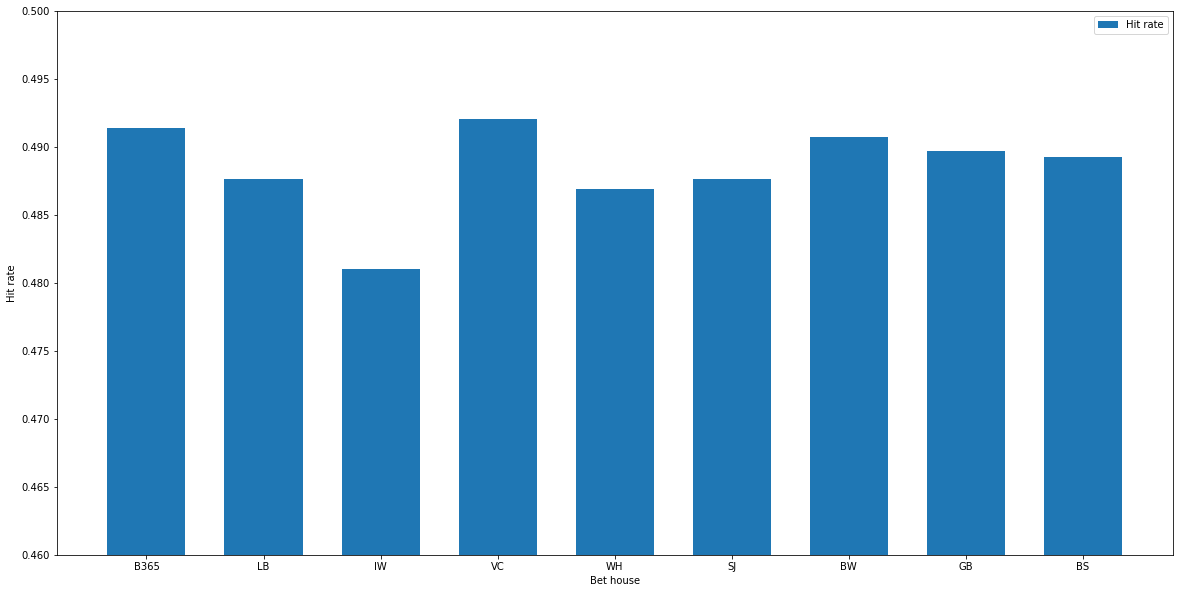

In [282]:
import matplotlib.pyplot as plt
import numpy as np

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.bar(hit_rate.keys().collect(), hit_rate.values().collect(), 1/1.5, label="Hit rate")
axes = plt.gca()
axes.set_ylim([0.46, 0.5])
plt.xlabel("Bet house")
plt.ylabel("Hit rate")
plt.legend()